## Regional Ocean: Basic Region and Surface Field Visualization

Note: This notebook is meant to be run with the cupid-analysis kernel (see [CUPiD Installation](https://ncar.github.io/CUPiD/index.html#installing)). This notebook is often run by default as part of [CESM post-processing steps](https://ncar.github.io/CUPiD/run_cesm.html), but you can also run it manually.

### Diagnostics and Plotting Resources
#### Highly Recommended:

[Xarray Fundamentals - Earth Environmental Data Science Course (recommend the entire course!)](https://earth-env-data-science.github.io/intro.html)

[MOM6 Analysis Cookbook](https://mom6-analysiscookbook.readthedocs.io/en/latest/index.html)

#### Great! Focused on Global Output Diagnostics

[MOM6 Tools (parimarily for global metrics)](https://mom6-tools.readthedocs.io/examples.html)

[MOM6 Diagnostics - CESM Tutorial](https://ncar.github.io/CESM-Tutorial/notebooks/diagnostics/mom/basics_mom.html)

#### Misc.

[MOM6 File Structure](https://regional-mom6.readthedocs.io/en/latest/mom6-file-structure-primer.html)

[xGCM - python package for staggered grids](https://xgcm.readthedocs.io/en/latest/xgcm-examples/03_MOM6.html)

In [1]:
%load_ext autoreload
%autoreload 2
import os

import matplotlib.pyplot as plt
import numpy as np
import regional_utils as utils
import xarray as xr
from cartopy import crs as ccrs

In [2]:
case_name = ""  # "/glade/campaign/cgd/oce/projects/CROCODILE/workshops/2025/Diagnostics/CESM_Output/"
CESM_output_dir = ""  # "CROCODILE_tutorial_nwa12_MARBL"

# As regional domains vary so much in purpose, simulation length, and extent, we don't want to assume a minimum duration
## Thus, we ignore start and end dates and simply reduce/output over the whole time frame for all of the examples given.
start_date = None  # "0001-01-01"
end_date = None  # "0101-01-01

save_figs = False
fig_output_dir = None

lc_kwargs = {}
serial = False

sfc_variables = []  # ['SSH', 'tos', 'sos', 'speed', 'SSV', 'SSU']
monthly_variables = []  # ['thetao', 'so', 'uo', 'vo']

In [3]:
# Parameters
case_name = "CROCODILE_tutorial_nwa12_MARBL"
CESM_output_dir = (
    "/glade/campaign/cgd/oce/projects/CROCODILE/workshops/2025/Diagnostics/CESM_Output/"
)
start_date = ""
end_date = ""
save_figs = True
fig_output_dir = None
lc_kwargs = {"threads_per_worker": 1}
serial = True
sfc_variables = ["tos"]
monthly_variables = ["thetao"]
subset_kwargs = {}
product = "/glade/work/ajanney/crocodile_2025/CUPiD/examples/regional_ocean/computed_notebooks//ocn/Regional_Ocean_Report_Card.ipynb"


In [4]:
OUTDIR = os.path.join(CESM_output_dir, case_name, "ocn", "hist")
print("Output directory is:", OUTDIR)

Output directory is: /glade/campaign/cgd/oce/projects/CROCODILE/workshops/2025/Diagnostics/CESM_Output/CROCODILE_tutorial_nwa12_MARBL/ocn/hist


## Load in Model Output and Look at Variables/Meta Data

#### Default File Structure in MOM6
This file structure will be different if you modify the diag_table.

- **static data**: contains horizontal grid, vertical grid, land/sea mask, bathymetry, lat/lon information
- **sfc data**: daily output of 2D surface fields (salinity, temp, SSH, velocities)
- **monthly data**: averaged monthly output of the full 3D domain, regridded to a predefined grid (MOM6 default is WOA, see more below)
- **native data**: averaged monthly output of ocean state and atmospheric fluxes on the native MOM6 grid

In [5]:
# Xarray time decoding things
time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)

## Static data includes hgrid, vgrid, bathymetry, land/sea mask
static_data = xr.open_mfdataset(
    os.path.join(OUTDIR, "*h.static.nc"),
    decode_timedelta=True,
    decode_times=time_coder,
    engine="netcdf4",
)

## Surface Data
sfc_data = xr.open_mfdataset(
    os.path.join(OUTDIR, "*h.sfc*.nc"),
    decode_timedelta=True,
    decode_times=time_coder,
    engine="netcdf4",
)

## Monthly Full Domain Data
## Not used in this notebook by default
monthly_data = xr.open_mfdataset(
    os.path.join(OUTDIR, "*h.z*.nc"),
    decode_timedelta=True,
    decode_times=time_coder,
    engine="netcdf4",
)

## Monthly Full Domain Data, on native MOM6 grid
## Not used in this notebook by default
native_data = xr.open_mfdataset(
    os.path.join(OUTDIR, "*h.native*.nc"),
    decode_timedelta=True,
    decode_times=time_coder,
    engine="netcdf4",
)

## Image/Gif Output Directory
if fig_output_dir is None:
    image_output_dir = os.path.join(
        "/glade/derecho/scratch/",
        os.environ["USER"],
        "archive",
        case_name,
        "ocn",
        "cupid_images",
    )
else:
    image_output_dir = os.path.join(fig_output_dir, case_name, "ocn", "cupid_images")
if not os.path.exists(image_output_dir):
    os.makedirs(image_output_dir)
print("Image output directory is:", image_output_dir)

Image output directory is: /glade/derecho/scratch/ajanney/archive/CROCODILE_tutorial_nwa12_MARBL/ocn/cupid_images


In [6]:
## Select for only the variables we want to analyze
if len(sfc_variables) > 0:
    print("Selecting only the following surface variables:", sfc_variables)
    sfc_data = sfc_data[sfc_variables]
if len(monthly_variables) > 0:
    print("Selecting only the following monthly variables:", monthly_variables)
    monthly_data = monthly_data[monthly_variables]

## Apply time boundaries
## if they are the right format
if len(start_date.split("-")) == 3 and len(end_date.split("-")) == 3:
    import cftime

    calendar = sfc_data.time.encoding.get("calendar", "standard")

    calendar_map = {
        "gregorian": cftime.DatetimeProlepticGregorian,
        "noleap": cftime.DatetimeNoLeap,
    }

    CFTime = calendar_map.get(calendar, cftime.DatetimeGregorian)
    y, m, d = [int(i) for i in start_date.split("-")]
    start_date_time = CFTime(y, m, d)
    y, m, d = [int(i) for i in end_date.split("-")]
    end_date_time = CFTime(y, m, d)

    print(
        f"Applying time range from start_date: {start_date_time} and end_date: {end_date_time}."
    )

    sfc_data = sfc_data.sel(time=slice(start_date_time, end_date_time))
    monthly_data = monthly_data.sel(time=slice(start_date_time, end_date_time))
    native_data = native_data.sel(time=slice(start_date_time, end_date_time))

sfc_time_bounds = [
    sfc_data["time"].isel(time=0).compute().item(),
    sfc_data["time"].isel(time=-1).compute().item(),
]
monthly_time_bounds = [
    monthly_data["time"].isel(time=0).compute().item(),
    monthly_data["time"].isel(time=-1).compute().item(),
]

print(f"Surface Data Time Bounds: {sfc_time_bounds[0]} to {sfc_time_bounds[-1]}")
print(
    f"Monthly Data Time Bounds: {monthly_time_bounds[0]} to {monthly_time_bounds[-1]}"
)

Selecting only the following surface variables: ['tos']
Selecting only the following monthly variables: ['thetao']
Surface Data Time Bounds: 1999-12-30 12:00:00 to 2000-11-28 12:00:00
Monthly Data Time Bounds: 2000-01-14 12:00:00 to 2000-10-14 12:00:00


#### **`*mom6.h.static*.nc`**: static information about the domain
The MOM6 grid uses an Arakawa C grid which staggers velocities and tracers (temp, salinity, SSH, etc.). See [this MOM6 documentation](https://mom6.readthedocs.io/en/main/api/generated/pages/Discrete_Grids.html#horizontal-grids) for more information.

##### Some variables of interest:
- **`geolon`/`geolat`** (and c/u/v variants): specifies the true lat/lon of each cell. We use these variables for plotting and placing the data geographically.
- **`wet`** (and c/u/v variants): the land-sea mask that specifies if a given point is on land or sea. 
- **`areacello`** (and bu,cu,cv variants): area of grid cell (important for taking area-weighted averages)
- **`deptho`**: depth of ocean floor - bathymetry

In [7]:
static_data

<xarray.Dataset> Size: 46MB
Dimensions:       (xh: 740, yh: 780, time: 1, xq: 741, yq: 781)
Coordinates:
  * xh            (xh) float64 6kB -97.96 -97.88 -97.79 ... -36.54 -36.46 -36.38
  * yh            (yh) float64 6kB 5.243 5.326 5.409 5.492 ... 53.82 53.86 53.89
  * time          (time) object 8B 0001-01-01 00:00:00
  * xq            (xq) float64 6kB -98.0 -97.92 -97.83 ... -36.5 -36.42 -36.33
  * yq            (yq) float64 6kB 5.201 5.284 5.367 5.45 ... 53.84 53.87 53.91
Data variables: (12/20)
    geolon        (yh, xh) float32 2MB dask.array<chunksize=(780, 740), meta=np.ndarray>
    geolat        (yh, xh) float32 2MB dask.array<chunksize=(780, 740), meta=np.ndarray>
    geolon_c      (yq, xq) float32 2MB dask.array<chunksize=(781, 741), meta=np.ndarray>
    geolat_c      (yq, xq) float32 2MB dask.array<chunksize=(781, 741), meta=np.ndarray>
    geolon_u      (yh, xq) float32 2MB dask.array<chunksize=(780, 741), meta=np.ndarray>
    geolat_u      (yh, xq) float32 2MB dask.array<chunksize=(780, 741), meta=np.ndarray>
    ...            ...
    areacello     (yh, xh) float32 2MB dask.array<chunksize=(780, 740), meta=np.ndarray>
    areacello_cu  (yh, xq) float32 2MB dask.array<chunksize=(780, 741), meta=np.ndarray>
    areacello_cv  (yq, xh) float32 2MB dask.array<chunksize=(781, 740), meta=np.ndarray>
    areacello_bu  (yq, xq) float32 2MB dask.array<chunksize=(781, 741), meta=np.ndarray>
    sin_rot       (yh, xh) float32 2MB dask.array<chunksize=(780, 740), meta=np.ndarray>
    cos_rot       (yh, xh) float32 2MB dask.array<chunksize=(780, 740), meta=np.ndarray>
Attributes:
    NumFilesInSet:  1
    title:          MOM6 diagnostic fields table for CESM case: marbl.bio.croc.5
    grid_type:      regular
    grid_tile:      N/A

<div class="alert alert-info">
<strong>Indexing and the Horizontal C-grid in MOM6</strong>

When accessing the output, we need to pay particular attention to which variables we are accessing and which coordinates correspond to their position on the grid. This also affects plotting and spatial averages (as we will see in this notebook and others). 
- `xh`/`yh`: index the center of the cell in `x` and `y` respectively
- `xq`/`yq`: index the corner of the cell in `x` and `y` respectively
  
<strong>Coordinates:</strong>
- (`xh`,`yh`): center of cell, where tracers are. Plot with `geolon`,`geolat`.
- (`xh`,`yq`): middle of horizontal interface, where meridional (v) velocity is. Plot with `geolon_v`,`geolat_v`.
- (`xq`,`yh`): middle of vertical interface, where zonal (u) velocity is. Plot with `geolon_u`,`geolat_u`.
- (`xq`,`yq`): corners between cells, where vorticity is.

</div>

#### **`*h.sfc*.nc`**: daily surface fields
The surface fields are especially useful for diagnosing short runs. This is not only the most dynamic field for short runs, but it also is the only file that stores daily results (by default). A lot of the diagnostics in this notebook use surface fields because we are able to take time averages and look at time series for any run longer than a couple of days (unlike the full 3D domain fields which are averaged over each month).

##### Some variables of interest:
- `SSH`: sea surface height
- `tos`: temperature of ocean surface
- `sos`: salinity of ocean surface
- `speed`: magnitude of speed (considered a tracer, at the center of a cell)
- `SSU` and `SSV`: zonal and meridional velocity at the surface

In [8]:
sfc_data

<xarray.Dataset> Size: 773MB
Dimensions:  (time: 335, yh: 780, xh: 740)
Coordinates:
  * xh       (xh) float64 6kB -97.96 -97.88 -97.79 ... -36.54 -36.46 -36.38
  * yh       (yh) float64 6kB 5.243 5.326 5.409 5.492 ... 53.82 53.86 53.89
  * time     (time) object 3kB 1999-12-30 12:00:00 ... 2000-11-28 12:00:00
Data variables:
    tos      (time, yh, xh) float32 773MB dask.array<chunksize=(31, 780, 740), meta=np.ndarray>
Attributes:
    NumFilesInSet:     1
    title:             MOM6 diagnostic fields table for CESM case: marbl.bio....
    associated_files:  areacello: marbl.bio.croc.5.mom6.h.static.nc
    grid_type:         regular
    grid_tile:         N/A

#### **`*h.z*.nc`**: fields for the full 3D domain, averaged monthly, regridded vertically
These are vertically remapped diagnostics files that capture the full 3D domain, but they only output monthly averages. For runs less than a month, they will average over the full length of the run. 

By default, this diagnostics MOM6 regrids output to the vertical grid from the 2009 World Ocean Atlas (35 layers down to 6750 m). 

##### Some variables of interest:
- `uo` and `vo`: zonal and meridional velocity
- `thetao`: potential temperature
- `so`: salinity
- `vmo` and `umo`: zonal and meridional mass transport 
- `volcello`: volume of each cell (important for averaging over a volume of the domain)

**Note:** now there are two `z` coordinates. `z_i` is the vertical interface between cells and `z_l` identifies the depth of the cell centers. 

In [9]:
monthly_data

<xarray.Dataset> Size: 808MB
Dimensions:  (time: 10, z_l: 35, yh: 780, xh: 740)
Coordinates:
  * yh       (yh) float64 6kB 5.243 5.326 5.409 5.492 ... 53.82 53.86 53.89
  * z_l      (z_l) float64 280B 2.5 10.0 20.0 32.5 ... 5.5e+03 6e+03 6.5e+03
  * time     (time) object 80B 2000-01-14 12:00:00 ... 2000-10-14 12:00:00
  * xh       (xh) float64 6kB -97.96 -97.88 -97.79 ... -36.54 -36.46 -36.38
Data variables:
    thetao   (time, z_l, yh, xh) float32 808MB dask.array<chunksize=(1, 35, 780, 740), meta=np.ndarray>
Attributes:
    NumFilesInSet:     1
    title:             MOM6 diagnostic fields table for CESM case: marbl.bio....
    associated_files:  areacello: marbl.bio.croc.5.mom6.h.static.nc
    grid_type:         regular
    grid_tile:         N/A

<div class="alert alert-info">
<strong>Note on Vertically Remapped Diagnostics in MOM6</strong>

The output found in `*mom6.h.z.*.nc` files is vertically remapped by MOM6. By default, this output is on the 2009 World Ocean Atlas grid. You can regrid the output after runtime (see packages like [xgcm](https://xgcm.readthedocs.io/en/latest/index.html) and and [xESMF](https://xesmf.readthedocs.io/en/stable/)), but if you know a vertical grid that you need output on, MOM6 can handle the interpolation automatically. 

The vertical grid settings for a particular CESM run can be found in `MOM_parameter_doc.all` in the CESM case run directory. See [this MOM6 documentation](https://mom6.readthedocs.io/en/main/api/generated/pages/Diagnostics.html#vertically-remapped-diagnostics) for more information.

</div>

#### **`*h.native*.nc`**: fields for the full 3D domain, averaged monthly, on native MOM6 grid.
These outputs are on the MOM6 native grid. From the [MOM6 Documentation](https://mom6.readthedocs.io/en/main/api/generated/pages/Diagnostics.html#native-diagnostics):
> Since the model can be run in arbitrary coordinates, say in hybrid-coordinate mode, then native-space diagnostics can be potentially confusing. Native diagnostics are useful when examining exactly what the model is doing

The default native file (as configured by CESM) also outputs useful global averages and atmospheric variables. 

##### Some variables of interest:
- `soga`: global mean ocean salinity
- `thetaoga`: global mean ocean potential temperature
- `tauuo` and `tauvo`: zonal and meridional downward stress from the atmospheric forcing
- `hfds`: net downward surface heat flux
  - `hf*`: various individual heat fluxes into the ocean
- `friver`: freshwater flux from rivers

In [10]:
native_data

<xarray.Dataset> Size: 39GB
Dimensions:               (time: 11, scalar_axis: 1, zl: 75, yh: 780, xq: 741,
                           yq: 781, xh: 740, zi: 76, nbnd: 2)
Coordinates:
  * scalar_axis           (scalar_axis) float64 8B 0.0
  * time                  (time) object 88B 2000-01-14 12:00:00 ... 2000-11-1...
  * nbnd                  (nbnd) float64 16B 1.0 2.0
  * xq                    (xq) float64 6kB -98.0 -97.92 -97.83 ... -36.42 -36.33
  * yh                    (yh) float64 6kB 5.243 5.326 5.409 ... 53.86 53.89
  * zl                    (zl) float64 600B 1.0 3.0 5.0 ... 6.125e+03 6.375e+03
  * xh                    (xh) float64 6kB -97.96 -97.88 ... -36.46 -36.38
  * yq                    (yq) float64 6kB 5.201 5.284 5.367 ... 53.87 53.91
  * zi                    (zi) float64 608B 0.0 2.0 4.0 ... 6.25e+03 6.5e+03
Data variables: (12/76)
    soga                  (time, scalar_axis) float32 44B dask.array<chunksize=(1, 1), meta=np.ndarray>
    thetaoga              (time, scalar_axis) float32 44B dask.array<chunksize=(1, 1), meta=np.ndarray>
    uh                    (time, zl, yh, xq) float32 2GB dask.array<chunksize=(1, 75, 780, 741), meta=np.ndarray>
    vh                    (time, zl, yq, xh) float32 2GB dask.array<chunksize=(1, 75, 781, 740), meta=np.ndarray>
    vhbt                  (time, yq, xh) float32 25MB dask.array<chunksize=(1, 781, 740), meta=np.ndarray>
    uhbt                  (time, yh, xq) float32 25MB dask.array<chunksize=(1, 780, 741), meta=np.ndarray>
    ...                    ...
    speed                 (time, yh, xh) float32 25MB dask.array<chunksize=(1, 780, 740), meta=np.ndarray>
    mlotst                (time, yh, xh) float32 25MB dask.array<chunksize=(1, 780, 740), meta=np.ndarray>
    average_T1            (time) object 88B dask.array<chunksize=(1,), meta=np.ndarray>
    average_T2            (time) object 88B dask.array<chunksize=(1,), meta=np.ndarray>
    average_DT            (time) timedelta64[ns] 88B dask.array<chunksize=(1,), meta=np.ndarray>
    time_bounds           (time, nbnd) object 176B dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes:
    NumFilesInSet:     1
    title:             MOM6 diagnostic fields table for CESM case: marbl.bio....
    associated_files:  areacello: marbl.bio.croc.5.mom6.h.static.nc
    grid_type:         regular
    grid_tile:         N/A

## Look at Regional Domain

In [11]:
%matplotlib inline

Note: you may see some numpy divide by zero errors below. I don't why, but they aren't an issue!

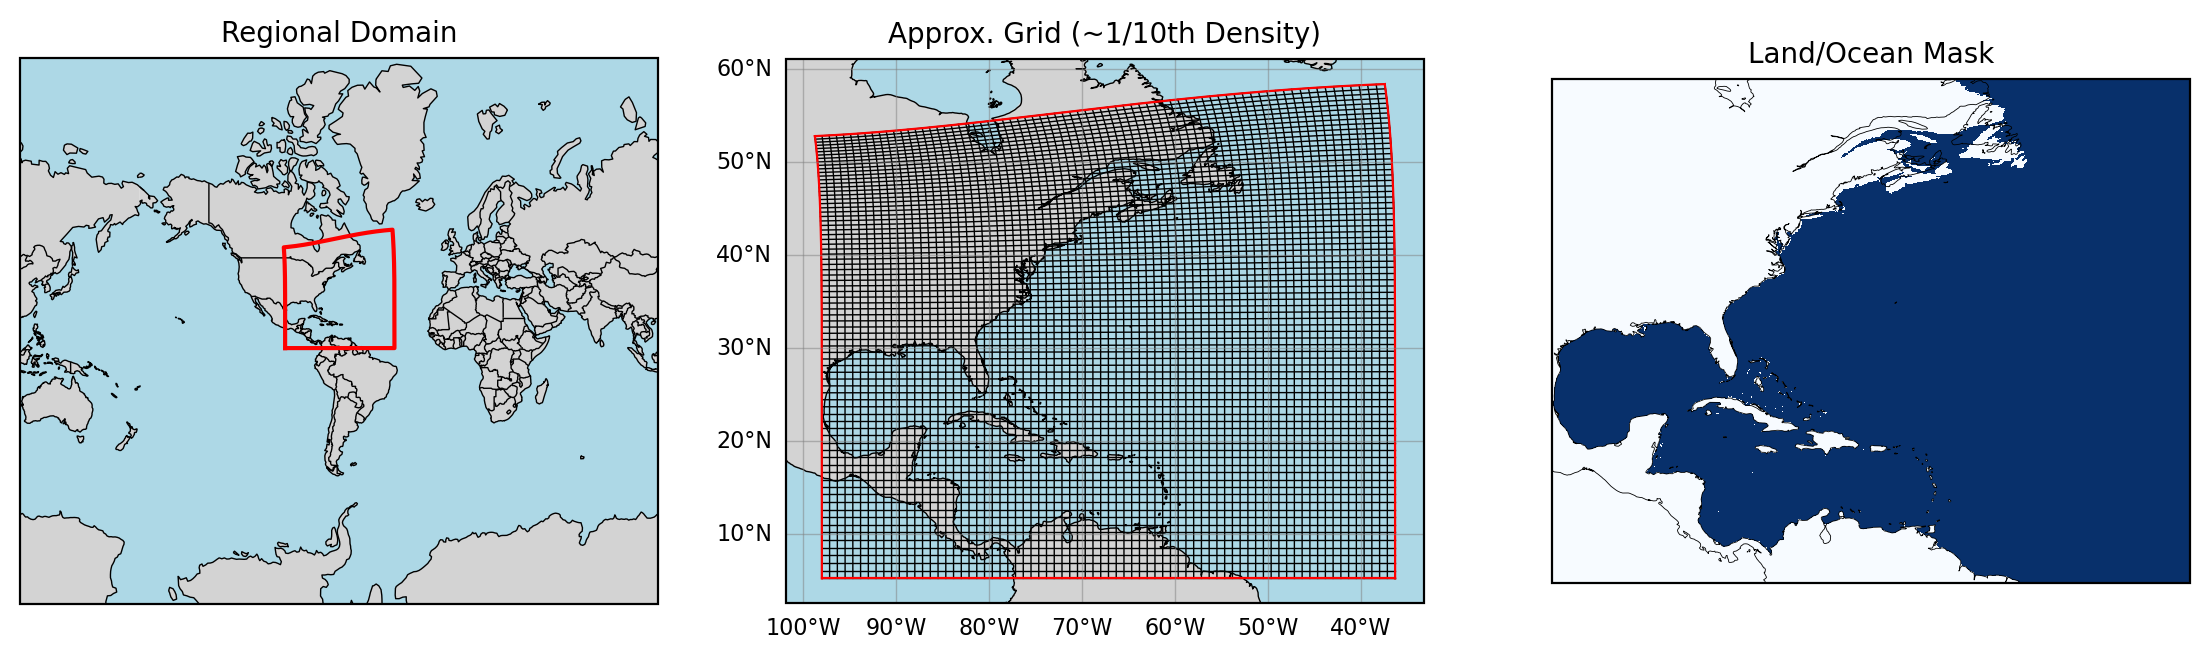

In [12]:
utils.visualizeRegionalDomain(static_data)

## Plotting Regional MOM6 Output
We will primarily look at the surface fields and some of the monthly full domain fields in this notebook. 

Xarray comes with great default plotting wrappers that can do a lot! If you take an Xarray DataArray (one variable data structure) and call 
```
xr.DataArray.plot()
```
it will usually do a pretty good job! Here we'll walk through some powerful ways to use this plot wrapper, and we provide some additional functions to help the plotting along!

### Simple plotting with Xarray

By default, these files are all loaded in as Datasets which store a large set of variables with a variety of shared coordinates/dimensions. 

When plotting, we need to reduce this space to a single variable. If we want to plot a spatial field we need one time step, and if we want to plot a timeseries, we need to average over the spatial dimensions (this is a bit more complicated than it might seem because the grid cells are not all the same size).

Let's use some basic Xarray plotting to look at a surface field:

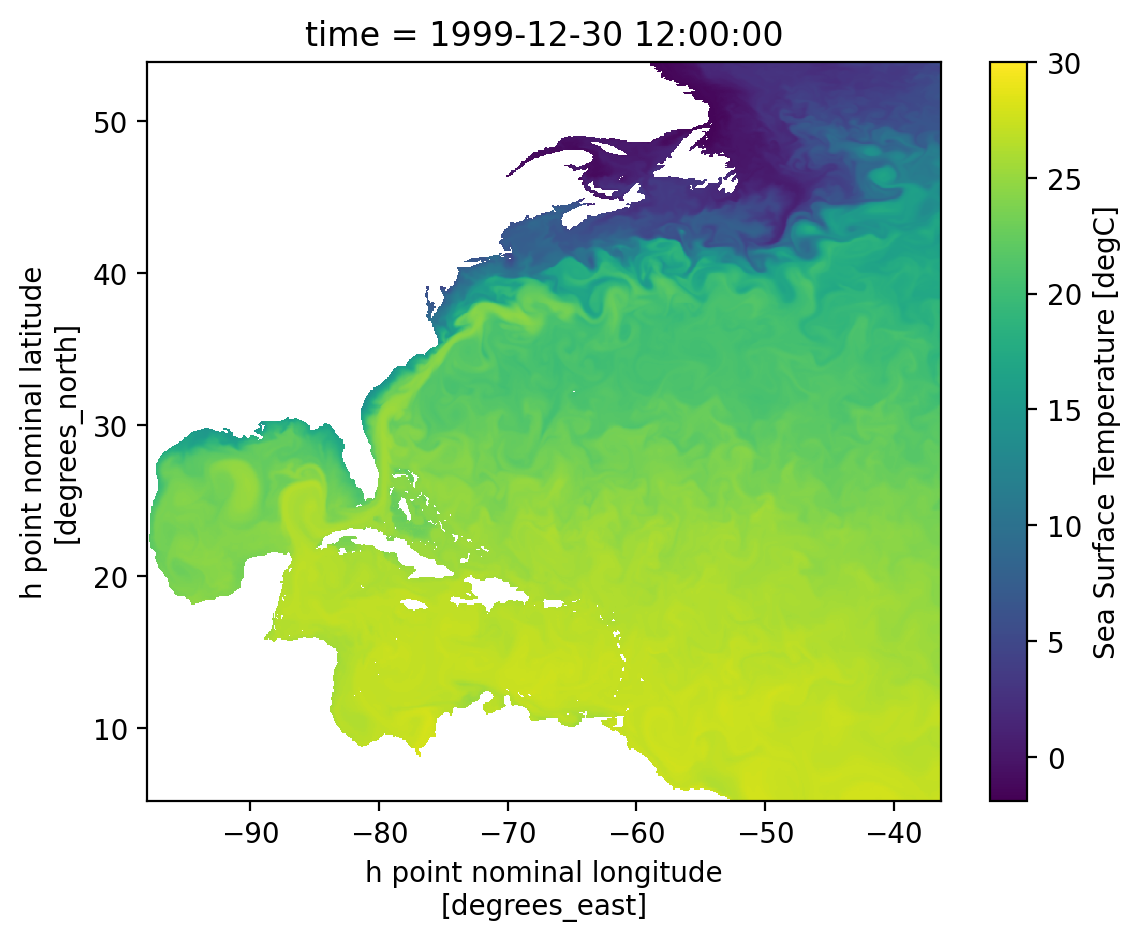

In [13]:
## Select a single variable at a single time
sst = sfc_data["tos"].isel(time=0)
sst.plot(cmap="viridis", vmin=-1.9, vmax=30)  # approx. color bar bounds for temp
# Note that it automatically labels with coordinate names and attributes.

Looks good! But from above we know we want to plot with `geolon` and `geolat` for an accurate map. We can also choose some different color maps and projections. Let's use some `regional_utils` to get this done. 

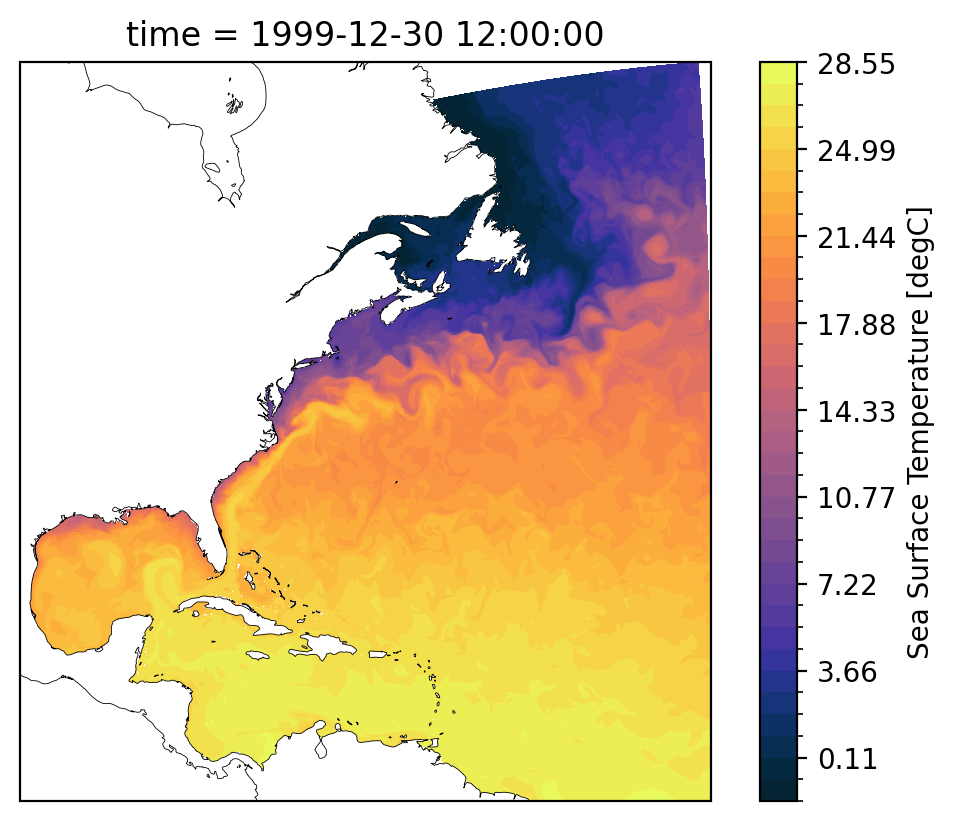

In [14]:
## Select a single variable at a single time
sst = sfc_data["tos"].isel(time=0)

coords = utils.chooseGeoCoords(sst.dims)
lat = static_data[coords["latitude"]]
lon = static_data[coords["longitude"]]

sst = sst.assign_coords({"lon": lon, "lat": lat})

cmap = utils.chooseColorMap(sst.name)

cbar_levels = utils.chooseColorLevels(
    sst.min().compute().item(),
    sst.max().compute().item(),
)

# Create the plot with projection
fig = plt.figure(dpi=200)
ax = plt.axes(projection=ccrs.Mercator())

# Plot the data
p = sst.plot(
    x="lon",
    y="lat",
    cmap=cmap,
    levels=cbar_levels,
    transform=ccrs.PlateCarree(),
    ax=ax,
    add_colorbar=True,
)

# Add coastlines - now this should work
ax.coastlines(resolution="50m", color="black", linewidth=0.3)

plt.show()

Looks good! Doing all this setup everytime would be cumbersome, so we wrapped it in a function `utils.plotLatLonField`. 

Please go check it out and see what's going on behind the scenes. It also can calculate statistics for the field taking into account area/volume weights. 

### MOM6 Output - Surface Fields

The cells below visualize the mean state and the std of the fields over the full time given.

Taking mean and std dev from 1999-12-30 12:00:00 to 2000-11-28 12:00:00


/glade/work/ajanney/conda-envs/cupid-analysis/lib/python3.11/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


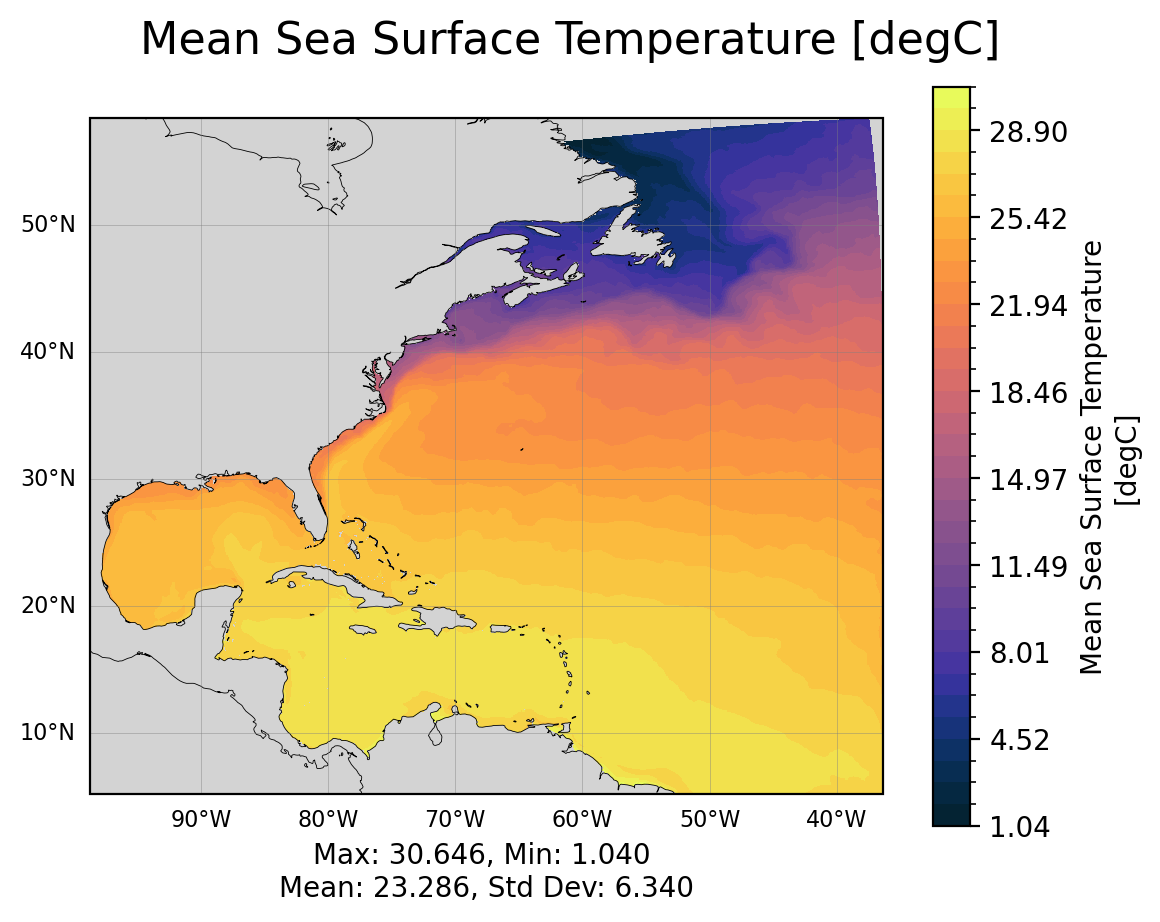

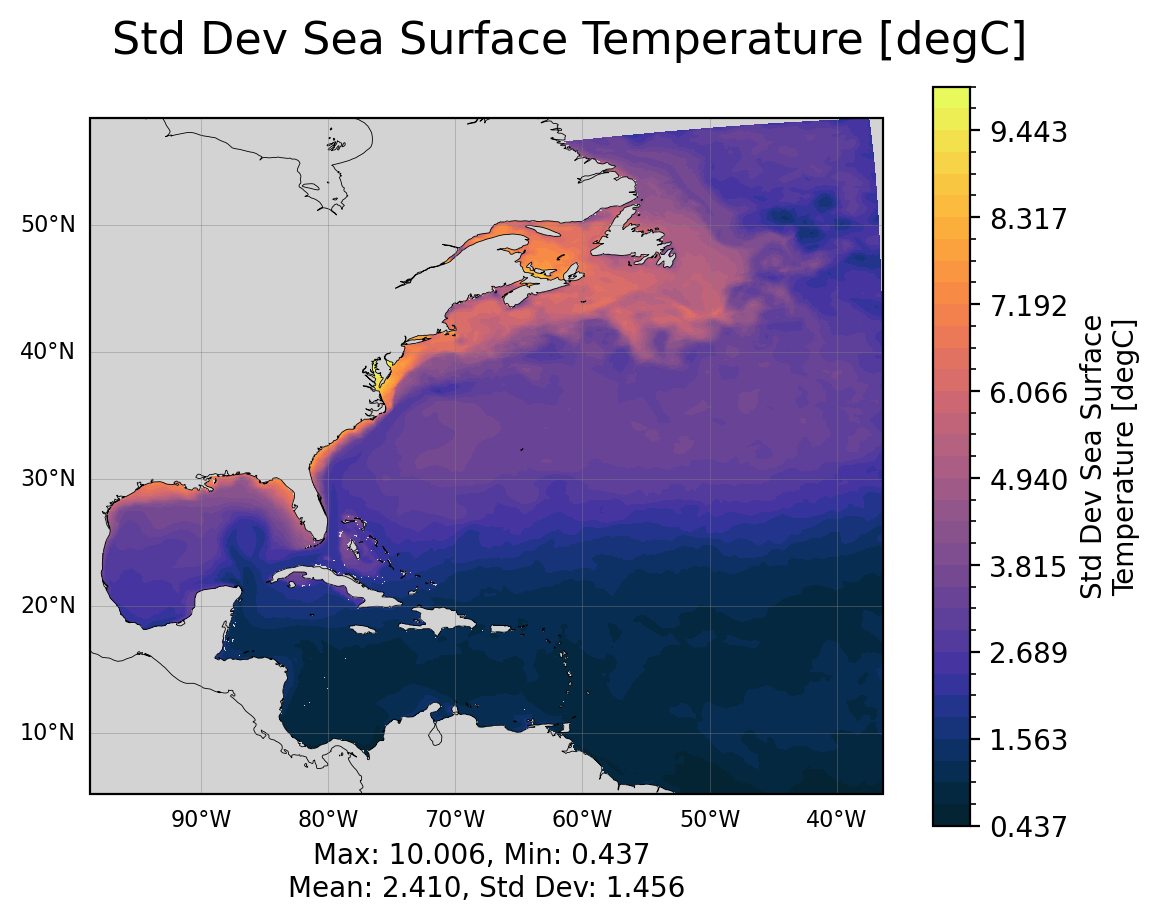

In [15]:
## Ploting basic surface state variables
add_stats = True
time_bounds = (
    sfc_data["time"][0].compute().item(),
    sfc_data["time"][-1].compute().item(),
)

for var in sfc_variables:
    if var not in list(sfc_data.variables):
        print(f"Variable '{var}' not in given sfc_data. It will not be plotted.")
        sfc_variables.remove(var)


print(f"Taking mean and std dev from {time_bounds[0]} to {time_bounds[-1]}")
for var in sfc_variables:
    field = sfc_data[var]

    coords = utils.chooseGeoCoords(field.dims)
    areacello = utils.chooseAreacello(field.dims)

    mean = field.mean(dim="time", skipna=True).compute()
    std = field.std(dim="time", skipna=True).compute()
    mean.attrs = field.attrs
    std.attrs = field.attrs
    mean.attrs["long_name"] = f"Mean {field.long_name}"
    std.attrs["long_name"] = f"Std Dev {field.long_name}"

    utils.plotLatLonField(
        mean,
        latitude=static_data[coords["latitude"]],
        longitude=static_data[coords["longitude"]],
        stats=add_stats,
        area_weights=static_data[areacello],
        save=save_figs,
        save_path=image_output_dir,
    )
    plt.show()

    utils.plotLatLonField(
        std,
        latitude=static_data[coords["latitude"]],
        longitude=static_data[coords["longitude"]],
        stats=add_stats,
        area_weights=static_data[areacello],
        save=save_figs,
        save_path=image_output_dir,
    )
    plt.show()

## Area Weighted Averages and Timeseries

Calculating and plotting timeseries can also be complicated. We need to be careful when taking an average of the fields that we take weighted statistics because the grid cells are not guaranteed to be constant area or volume. 

The information we need for these weighted averages is contained in the `areacello*` variables (in static_data) and the `volcello` variable (in native_data and monthly_data).

We have to pay attention to coordinates and dimensions because of MOM6's staggered grid (see how we choose the geolon/lat coords above).

**Note:** These timeseries may be less helpful for shorter runs, but see what they reveal!

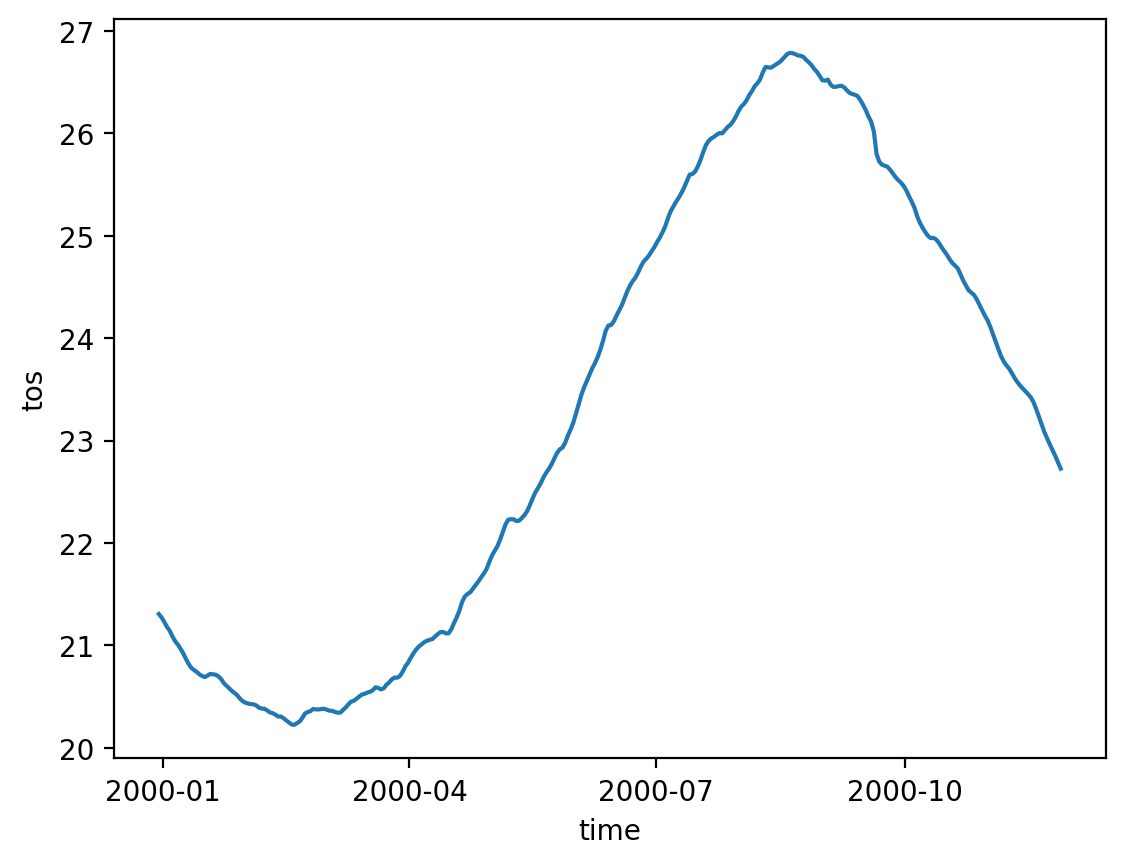

In [16]:
for var in sfc_variables:
    field = sfc_data[var]
    areacello_var = utils.chooseAreacello(field.dims)

    utils.plotAvgTimeseries(
        sfc_data[var],
        static_data[areacello_var],
        save=save_figs,
        save_path=image_output_dir,
    )

## Viewing Full Domain Monthly Output

Let's look at the monthly output. When using longer runs (years or decades). These hold a lot more information about how your model is evolving and performing over time. For shorter runs (like many regional models often are), we may only have a handful of monthly output timesteps. 

Xarray has some very useful methods for visualizing multiple levels and easily plotting them using the `col` and `col_wrap` keywords. 

**Note: ** none of the following plots are saved. If you want to save them, rerun the first few cells of the notebook and manually save these.

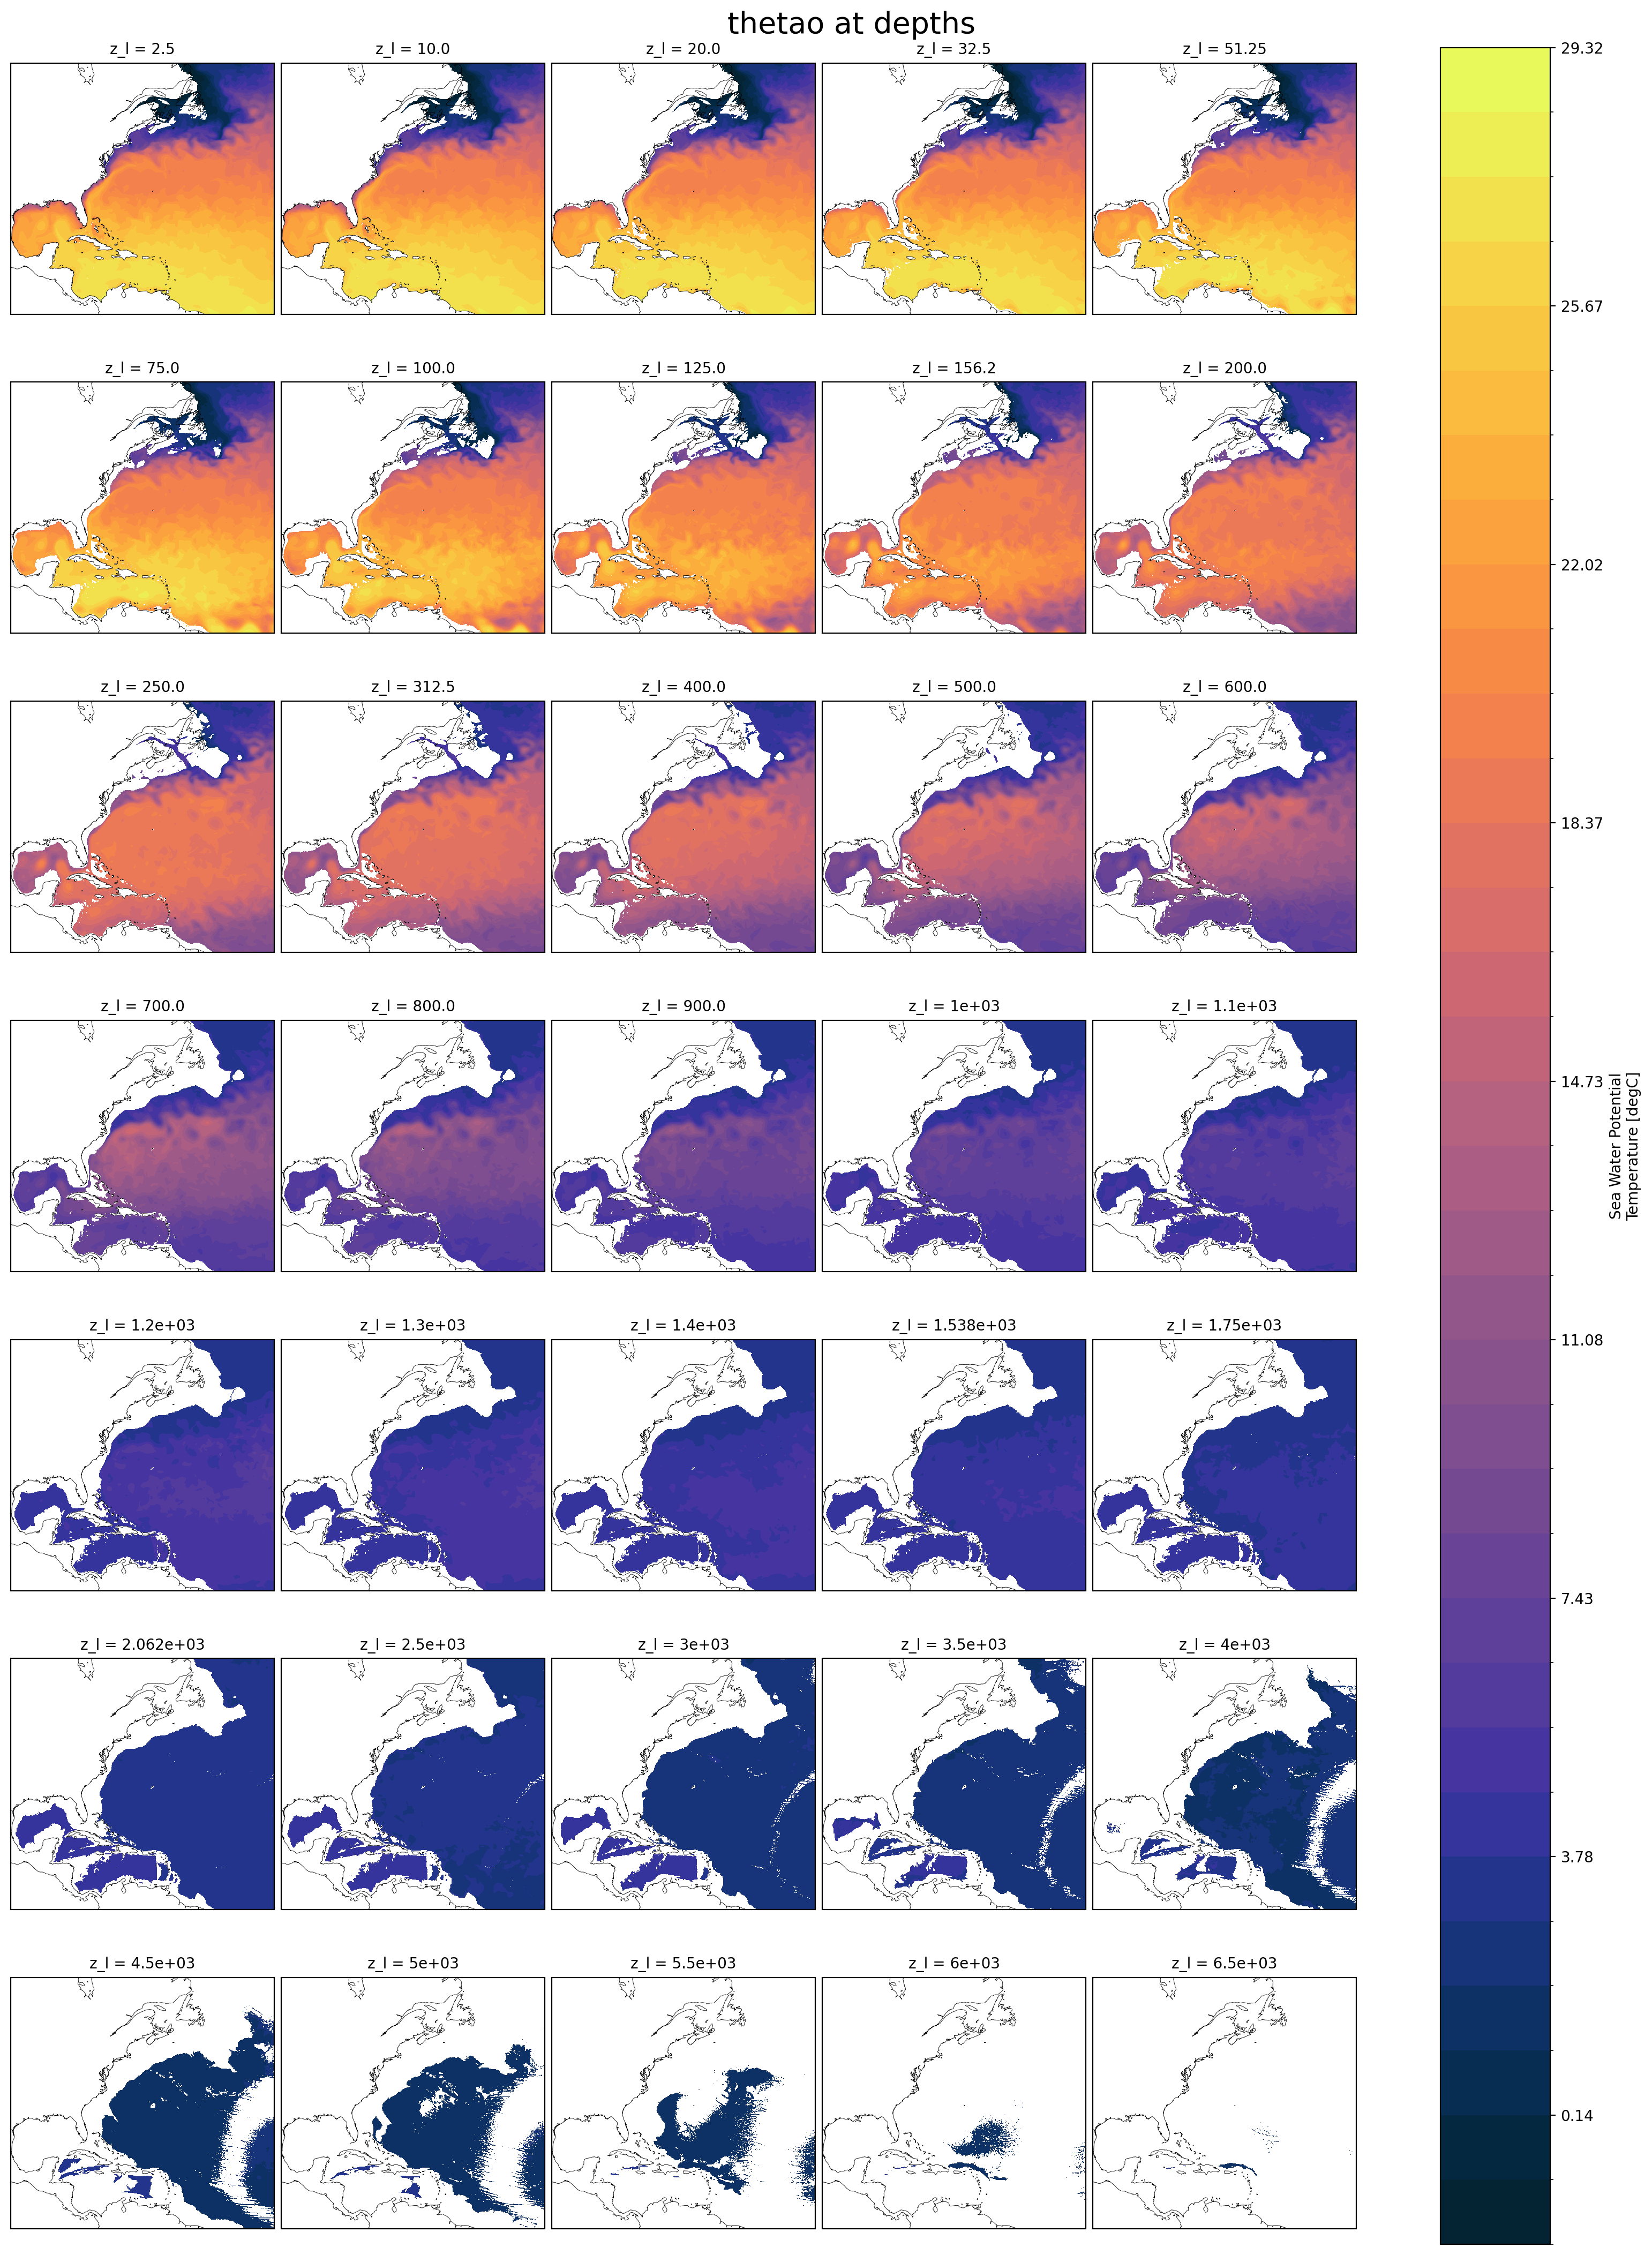

In [17]:
for var in monthly_variables:
    if var not in list(monthly_data.variables):
        print(f"Variable '{var}' not in given monthly_data. It will not be plotted.")
        monthly_variables.remove(var)

## Let's only look at one variable for now (this plotting can be slow)
for var in monthly_variables[0:1]:
    # Look at only the first time step for now
    field = monthly_data[var].isel(time=0)

    cmap = utils.chooseColorMap(var)
    levels = utils.chooseColorLevels(
        field.min().compute().item(),
        field.max().compute().item(),
    )

    subplot_kwargs = {
        "projection": ccrs.Mercator(),
    }

    p = field.plot(
        col="z_l",
        col_wrap=5,
        cmap=cmap,
        levels=levels,
        transform=ccrs.PlateCarree(),
        subplot_kws=subplot_kwargs,
    )
    plt.suptitle(f"{var} at depths", y=1.0, fontsize=20)

    for ax in p.axs.flat:
        ax.coastlines(resolution="50m", color="black", linewidth=0.3)

### Vertical Profiles
Another useful tool, sometimes we want to look at the vertical profile of something like salinity or temperature. Be careful to use area weighted averages here. (This could be a tool in regional_utils, but it's not too much code, you decide!)


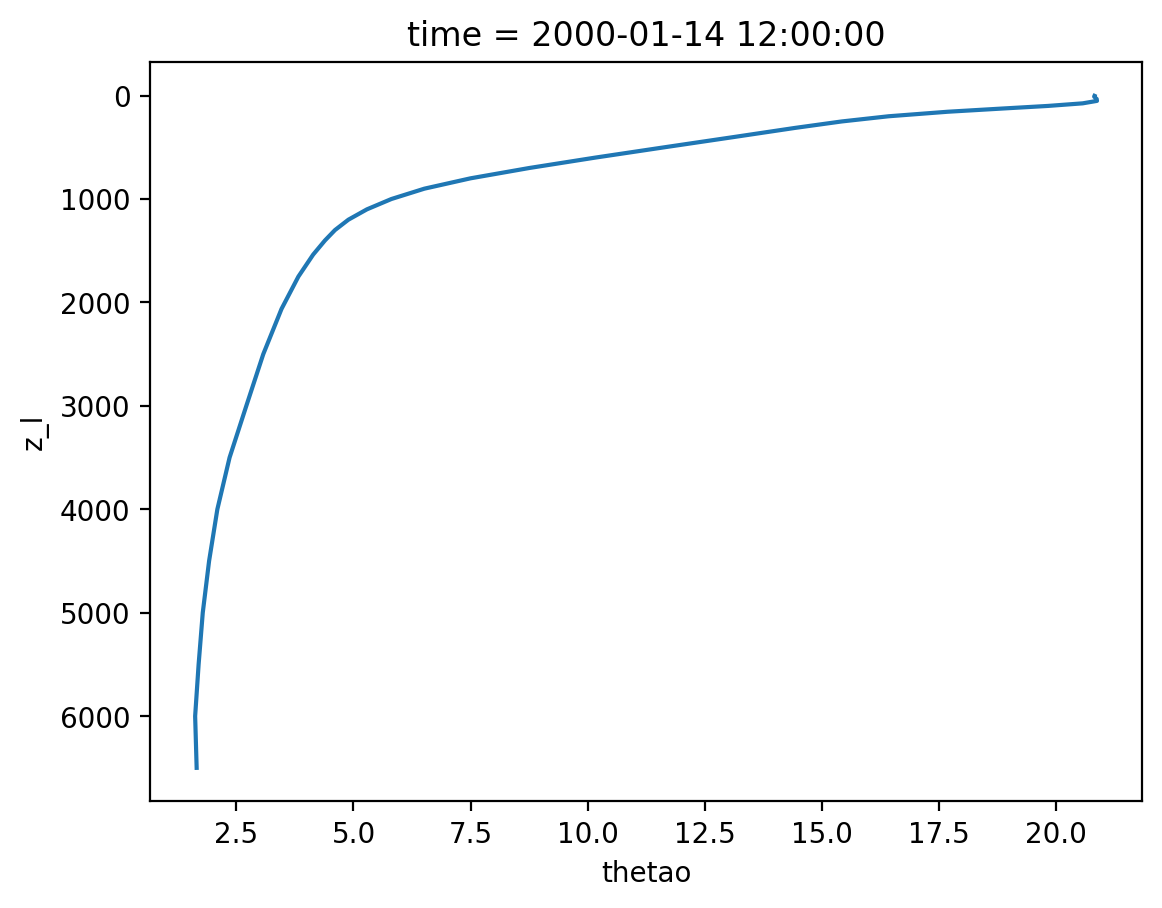

In [18]:
for var in monthly_variables[0:1]:  # only one variable again, make it more!
    # Look at only the first time step for now
    field = monthly_data[var].isel(time=0)

    area_weights = utils.chooseAreacello(field.dims)
    field_weighted = field.weighted(static_data[area_weights])

    mean_vars = [dim for dim in field.dims if dim != "z_l"]
    field_mean = field_weighted.mean(mean_vars)

    field_mean.plot(y="z_l", yincrease=False)

### Bonus: Interpolating Levels and Slices
We successfully plotted different levels above, we can also plot vertical slices. In both cases, we might run into an issue where we want to interpolate to a depth or lat/lon that is not explicitly resolved in the model. We can write our own tailored methods for this, but for simple visual inspection/comparison Xarray tools work well!

In [19]:
monthly_data["z_l"]

<xarray.DataArray 'z_l' (z_l: 35)> Size: 280B
array([2.5000e+00, 1.0000e+01, 2.0000e+01, 3.2500e+01, 5.1250e+01, 7.5000e+01,
       1.0000e+02, 1.2500e+02, 1.5625e+02, 2.0000e+02, 2.5000e+02, 3.1250e+02,
       4.0000e+02, 5.0000e+02, 6.0000e+02, 7.0000e+02, 8.0000e+02, 9.0000e+02,
       1.0000e+03, 1.1000e+03, 1.2000e+03, 1.3000e+03, 1.4000e+03, 1.5375e+03,
       1.7500e+03, 2.0625e+03, 2.5000e+03, 3.0000e+03, 3.5000e+03, 4.0000e+03,
       4.5000e+03, 5.0000e+03, 5.5000e+03, 6.0000e+03, 6.5000e+03])
Coordinates:
  * z_l      (z_l) float64 280B 2.5 10.0 20.0 32.5 ... 5.5e+03 6e+03 6.5e+03
Attributes:
    units:      meters
    long_name:  Depth at cell center
    axis:       Z
    positive:   down
    edges:      z_i

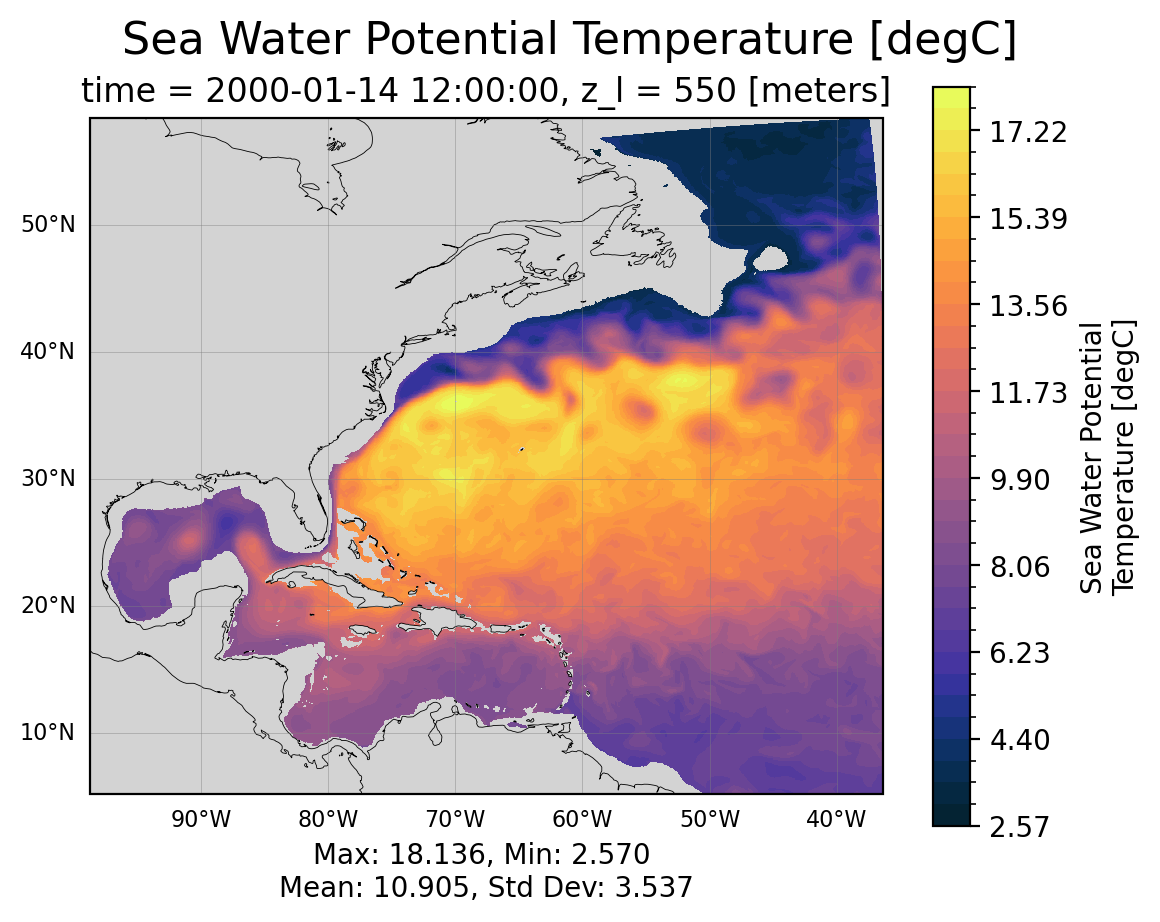

In [20]:
## Plot a specific depth
field = monthly_data["thetao"].isel(time=0)
field = field.interp(
    z_l=550, method="linear"
)  # you may choose a different depth if you want to test the interpolation

coords = utils.chooseGeoCoords(field.dims)
areacello = utils.chooseAreacello(field.dims)

utils.plotLatLonField(
    field,
    latitude=static_data[coords["latitude"]],
    longitude=static_data[coords["longitude"]],
    stats=True,
    area_weights=static_data[areacello],
    save=save_figs,
    save_path=image_output_dir,
)
plt.show()

#### Let's try it with a vertical slice now too!

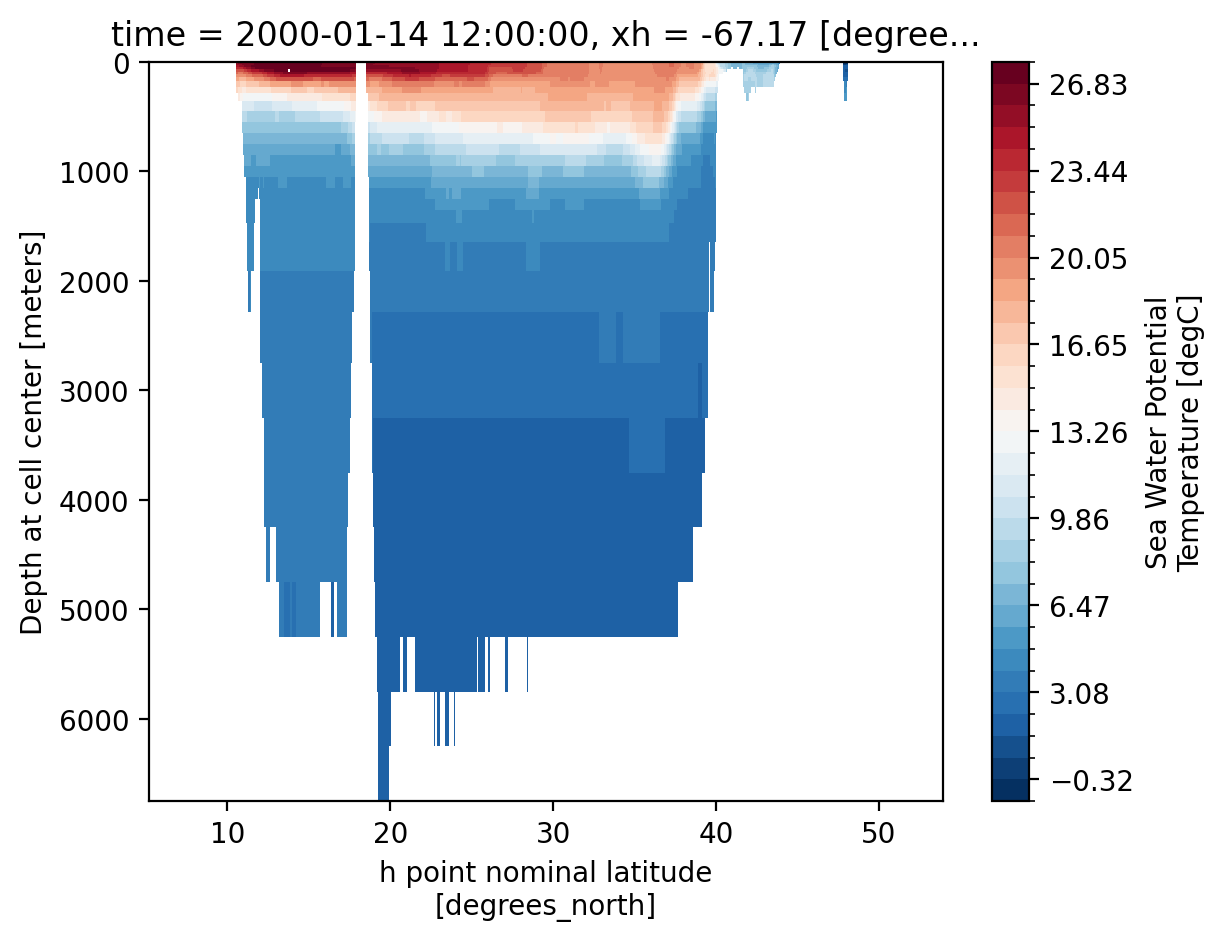

In [21]:
field = monthly_data["thetao"].isel(time=0)
x_var = "xh" if "xh" in field.dims else "xq"
longitude = np.mean(field[x_var].to_numpy())
vertical = field.interp({x_var: longitude})
levels = np.linspace(
    vertical.min().compute().item(), vertical.max().compute().item(), 35
)
vertical.plot(
    yincrease=False,
    levels=levels,
)